# Cornershop's Data Science Test

## Dev: Mateus Broilo
mateus.brilo90@gmail.com

* Objectives: Data handlings by cleaning, adjusting missing values and creating features.

# Summary

* Initials
    * Loading Libraries and Packages
    * Configurations
    * Global Variables
    * Function's Definition
        * Replace Missing Values
        * Expand dates, create day of the week column and transform time to pure number
        * Calculate the distance between the deliver and the branch location
        * Calculate number of type of itens, weight and distinct itens per order
        * Freeze Outliers in the corresponding percentile value
* Loading data
    * To Train & Test
* Data Preprocessing
    * Replace Missing Values
        * Resources: found_rate, accepted_rate and rating
            * found_rate, accepted_rate and rating distributions taking into account the missing entries
            * found_rate, accepted_rate and rating distributions with treated missing entries
        * Resources: quantity and buy_unit
        * Checking remaining missings
    * Feature Engineering
        * Creating the resources: day_of_week and pure_time
        * Creating ther resource: distance
        * Creating the resources: number of itens, weight and distinct items per order
    * Selecting Possible Useful Resources
    * Outlier Analysis
        * Percentile-Freeze
        * Exporting Outlier Dictionary
    * Saving preprocessed dataset
        



# Initials
* Loading Libraries and Packages
* Configuration
* Global Variables
* Function's Definition
     * Replace Missing Values
     * Expand dates, create day of the week column and transform time to pure number
     * Calculate the distance between the deliver and the branch location
     * Calculate number of type of itens, weight and distinct itens per order
     * Freeze Outliers in the corresponding percentile value

## Loading Libraries and Packages

In [1]:
# general
import warnings
import time
import gc

#data
import pandas as pd
import numpy as np
from datetime import (datetime, date)
import geopy.distance

## visualization
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
ls ..\data\

 O volume na unidade C nÃ£o tem nome.
 O NÃºmero de SÃ©rie do Volume Ã© 1210-43E2

 Pasta de C:\Users\mbroilo\Documents\Arbeit\Personal\projects\cornershop\data

01/04/2022  10:48    <DIR>          .
31/03/2022  18:23    <DIR>          ..
29/03/2022  20:02        64.304.021 20220329_merged_full.csv
29/03/2022  20:02        12.563.082 20220329_merged_predict.csv
29/03/2022  20:03        51.741.160 20220329_merged_train_test.csv
31/03/2022  19:51         1.325.626 20220331_prep_20220329_merged_train_test.csv
               4 arquivo(s)    129.933.889 bytes
               2 pasta(s)   144.303.202.304 bytes disponÃ­veis


## Configurations

In [3]:
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

rc={'font.size': 14, 'axes.labelsize': 14, 'legend.fontsize': 12, 
    'axes.titlesize': 24, 'xtick.labelsize': 14, 'ytick.labelsize': 12}

sns.set(rc=rc)
sns.set_palette("Set2")
sns.set_style("darkgrid")#sns.set_style("whitegrid")

## Global Variables

In [4]:
PATH_RAWDATA = "../raw_data/"
PATH_DATA = "../data/"
DATASET_TT = "20220329_merged_train_test.csv"
DATE = time.strftime("%Y%m%d")

## Function's Definition

### Replace Missing Values

In [5]:
def replaceNull(df, col, change):
    """
    Describe the function!
    """
    df[col] = df[col].replace(np.nan, change)

### Expand dates, create day of the week column and transform time to pure number

In [6]:
def dateTimeConverter(dataset, col):
    """
    Describe the function!
    """
    day_of_week = list(pd.to_datetime(dataset[col], format='%Y-%m-%d').dt.dayofweek)
    dataset['day_of_week'] = day_of_week
    dataset[[col+'_DATE', col+'_HOUR']] = dataset[col].str.split(" ", expand=True)
    dataset[[col+'_HOUR', col+'_HOUR2']] = dataset[col+'_HOUR'].str.split("+", expand=True)
    dataset[[col+'_HH', col+'_MIN', col+'_SEC']] = dataset[col+'_HOUR'].str.split(":", expand=True)
    dataset['pure_time'] = dataset[col+'_HH'].astype(int) + (dataset[col+'_MIN'].astype(int) / 60) + (dataset[col+'_SEC'].astype(float) / 3600)
    
    dataset['day_of_week'] = dataset['day_of_week'].map(
        {
            0:'monday',
            1:'tuesday',
            2:'wednesday',
            3:'thursday',
            4:'friday',
            5:'saturday',
            6:'sunday'
        }
    )
    
    del dataset[col+'_HOUR2'], dataset[col+'_HH'], dataset[col+'_MIN'], dataset[col+'_SEC']
        
    return dataset

### Calculate the distance between the deliver and the branch location

In [7]:
def calculateDistance(dataset, latX, lngX, latY, lngY):
    """
    Describe the function!
    """
    coordsX = list(zip(dataset[latX], dataset[latX]))
    coordsY = list(zip(dataset[latY], dataset[latY]))
    
    dataset['coordsX'] = coordsX
    dataset['coordsY'] = coordsY
    dist = []
                   
    for i in range(len(dataset)):
        distCalc = geopy.distance.distance(coordsX[i], coordsY[i]).km
        dist.append(distCalc)

    dataset['distance'] = dist
    
    return dataset

### Calculate number of type of itens, weight and distinct itens per order

In [8]:
def calculateItem(dataset, colUnit, colQuantity):
    """
    Describe the function!
    """
    no_item = []
    weight = []

    for i in range(len(dataset)):
        if dataset[colUnit][i] == 'UN':
            no_item.append(dataset[colQuantity][i])
            weight.append(0)
        elif dataset[colUnit][i] == 'KG':
            no_item.append(1)
            weight.append(dataset[colQuantity][i])
        else:
            no_item.append(np.nan)
            weight.append(np.nan)

    dataset['no_item'] = no_item
    dataset['weight'] = weight
    
    return dataset

### Freeze Outliers in the corresponding percentile value

In [9]:
def funcFreezeOutlier(dataset, listCol, percentiles, ifHigh=True):
    """
    This function freezes the value of an outlier marked entry
    respective in the corresponding value in a given percentile.

    Args:
        dataset (object/spreadsheet): The dataset under analysis.
        listCol (str list): List containing the columns of the dataset under analysis.
        percentile (float): Percentile in which the entry will be freezed.
        ifHigh (boolean): If True then freeze above percentile, else freeze below.

    Returns:
        table (object/spreadsheet): Some infos related to the freezed outliers.
        df_freezed (object/spreadsheet): Table with regularised outliers,
    """       
    data = []

    qtl = dataset[listCol].quantile(percentiles)

    for col in listCol:
        if ifHigh:
            count = len(dataset[col].loc[dataset[col] > qtl[col]])
            dataset[col].loc[dataset[col] > qtl[col]] = qtl[col]
        else:
            count = len(dataset[col].loc[dataset[col] < qtl[col]])
            dataset[col].loc[dataset[col] < qtl[col]] = qtl[col]
            
        data.append([percentiles*100, dataset[col].quantile(percentiles), count])
        
    table = pd.DataFrame(data, columns=['PERCENTILE', 'FREEZED VALUE', 'COUNT']).set_index([listCol])
    df_freezed = dataset.copy()
    
    return df_freezed, table

# Loading Data
* To Train & Test

## To Train & Test

In [10]:
df_tt = pd.read_csv(PATH_DATA + DATASET_TT, sep=',')
df_tt['item'] = 1 # add this column only to groupby the dataset
print(df_tt.shape)
df_tt.head()

(158325, 20)


,order_id,lat_order,lng_order,promised_time,on_demand,shopper_id,store_branch_id,total_minutes,seniority,found_rate,picking_speed,accepted_rate,rating,store_id,lat_storebranch,lng_storebranch,product_id,quantity,buy_unit,item
0,e750294655c2c7c34d83cc3181c09de4,-33.501675,-70.579369,2019-10-18 20:48:00+00:00,True,e63bc83a1a952fa2b3cc9d558fb943cf,65ded5353c5ee48d0b7d48c591b8f430,67.684264,6c90661e6d2c7579f5ce337c3391dbb9,0.9024,1.3,0.92,4.76,c4ca4238a0b923820dcc509a6f75849b,-33.48528,-70.57925,fb3336fca8851437f980e83045e75749,0.581,KG,1
1,e750294655c2c7c34d83cc3181c09de4,-33.501675,-70.579369,2019-10-18 20:48:00+00:00,True,e63bc83a1a952fa2b3cc9d558fb943cf,65ded5353c5ee48d0b7d48c591b8f430,67.684264,6c90661e6d2c7579f5ce337c3391dbb9,0.9024,1.3,0.92,4.76,c4ca4238a0b923820dcc509a6f75849b,-33.48528,-70.57925,dab05166de7d42c526f5627acad97902,1.000,UN,1
2,e750294655c2c7c34d83cc3181c09de4,-33.501675,-70.579369,2019-10-18 20:48:00+00:00,True,e63bc83a1a952fa2b3cc9d558fb943cf,65ded5353c5ee48d0b7d48c591b8f430,67.684264,6c90661e6d2c7579f5ce337c3391dbb9,0.9024,1.3,0.92,4.76,c4ca4238a0b923820dcc509a6f75849b,-33.48528,-70.57925,c49f0bd639bcbee3c331abdb48b653da,1.000,UN,1
3,e750294655c2c7c34d83cc3181c09de4,-33.501675,-70.579369,2019-10-18 20:48:00+00:00,True,e63bc83a1a952fa2b3cc9d558fb943cf,65ded5353c5ee48d0b7d48c591b8f430,67.684264,6c90661e6d2c7579f5ce337c3391dbb9,0.9024,1.3,0.92,4.76,c4ca4238a0b923820dcc509a6f75849b,-33.48528,-70.57925,16984fbb57316494a14543ad6d70a2e8,1.000,UN,1
4,e750294655c2c7c34d83cc3181c09de4,-33.501675,-70.579369,2019-10-18 20:48:00+00:00,True,e63bc83a1a952fa2b3cc9d558fb943cf,65ded5353c5ee48d0b7d48c591b8f430,67.684264,6c90661e6d2c7579f5ce337c3391dbb9,0.9024,1.3,0.92,4.76,c4ca4238a0b923820dcc509a6f75849b,-33.48528,-70.57925,fbfb98804142023129c9475f72db5b08,1.000,UN,1


# Data Preprocessing
* Replace Missing Values
    * Resources from mg2_tt: found_rate, accepted_rate and rating
        * found_rate, accepted_rate and rating distributions taking into account the missing entries
        * found_rate, accepted_rate and rating distributions with treated missing entries
    * Resources: quantity and buy_unit
    * Checking remaining missings
* Feature Engineering
    * Creating the resources: day_of_week and pure_time
    * Creating the resource: distance
    * Creating the resources: number of itens, weight and distinct items per order
* Selecting Possible Useful Resources
* Outlier Analysis
    * Percentile-Freeze
    * Exporting Outlier Dictionary
* Saving preprocessed dataset

In [11]:
df_prep = df_tt.copy()

## Replace Missing Values

### Resources from: found_rate, accepted_rate and rating

#### found_rate, accepted_rate and rating distributions taking into account the missing entries

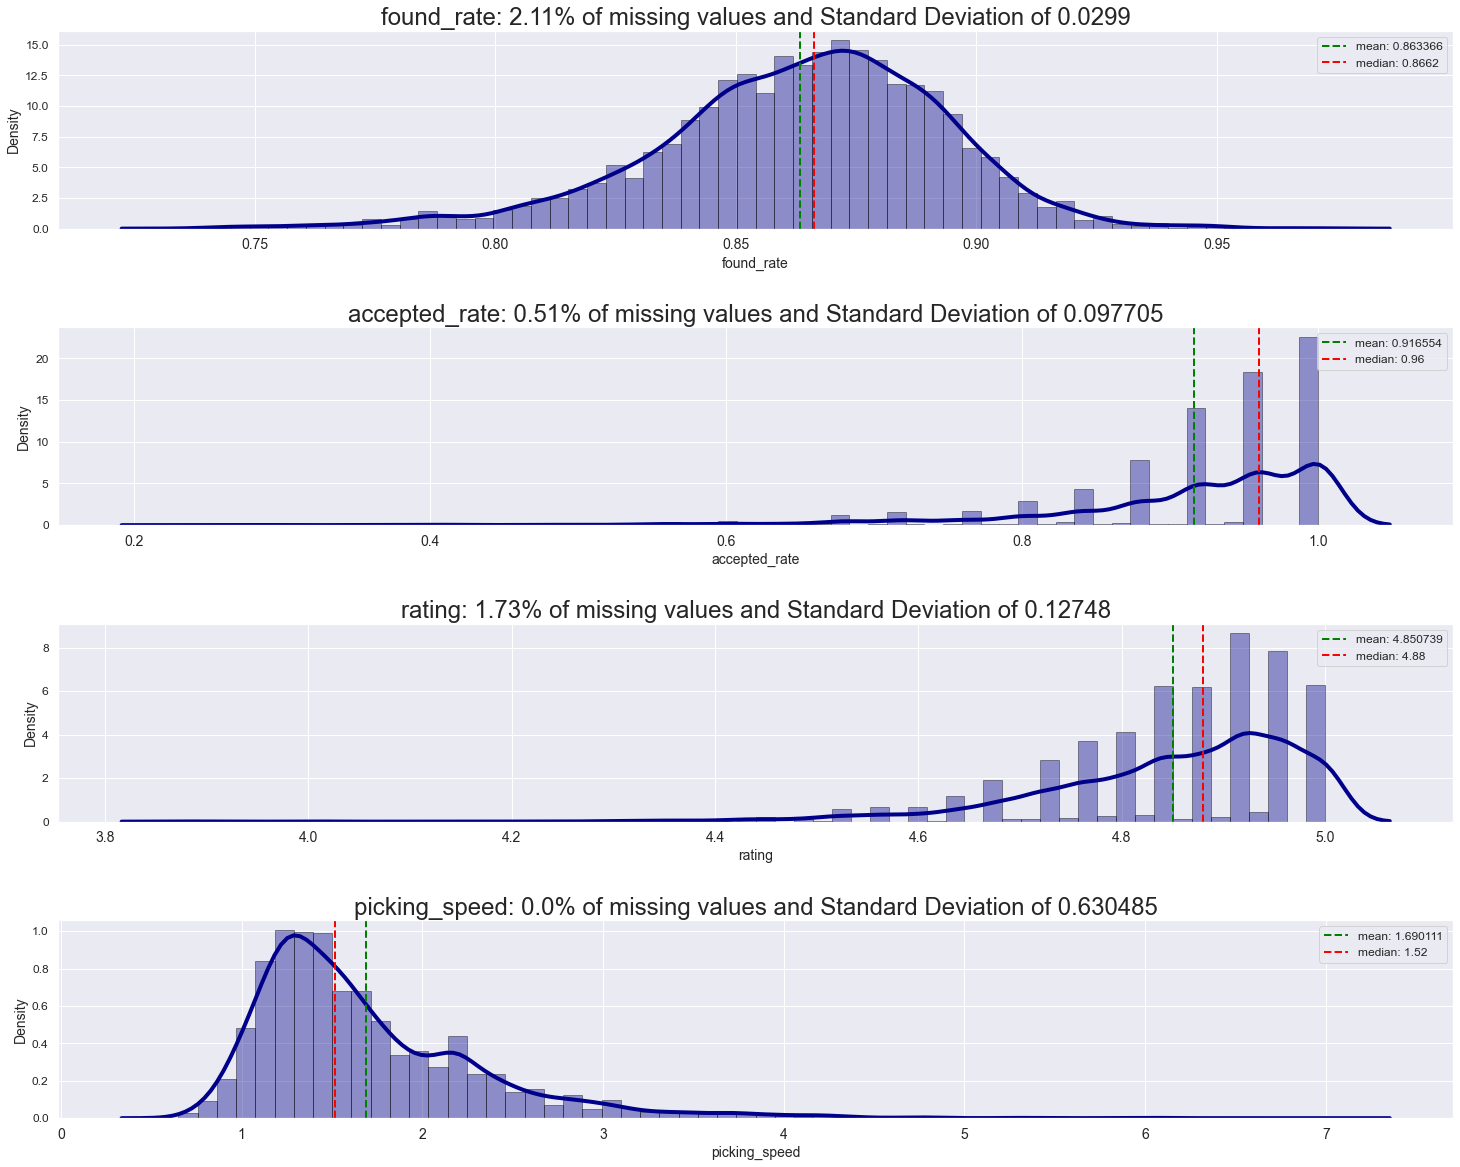

In [12]:
macro = df_prep.groupby(by='order_id').mean()

fig = plt.figure(figsize=(25,20))
fig.subplots_adjust(hspace=0.5, wspace=0.2)

j=1
for i in ['found_rate','accepted_rate','rating', 'picking_speed']:
    plot = plt.subplot(4, 1, j)
    ax = sns.distplot(macro[i], hist=True, kde=True, 
             bins=int(180/3), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
    
    ax.axvline(macro[i].mean(), 
               color='green', 
               linestyle='dashed', 
               linewidth=2, 
               label=f"mean: {str(macro[i].mean().round(6))}")
    
    ax.axvline(macro[i].median(), 
               color='red', 
               linestyle='dashed', 
               linewidth=2, 
               label=f"median: {str(macro[i].median().round(6))}")
    
    plt.title(f"{i}: {round(len(macro[i][macro[i].isnull()==True])/len(macro[i]) * 100, 2)}% of missing values and Standard Deviation of {str(macro[i].std().round(6))}")
    plt.legend(loc='upper right')
    j += 1

del ax

**DECISION:** Replace it by median, since it's less affected by outliers

In [13]:
print(f"found_rate median: {df_prep.groupby(by='order_id').median()['found_rate'].median()}")
print(f"accepted_rate median: {df_prep.groupby(by='order_id').median()['accepted_rate'].median()}")
print(f"rating median: {df_prep.groupby(by='order_id').median()['rating'].median()}")

found_rate median: 0.8662
accepted_rate median: 0.96
rating median: 4.88


In [14]:
# found_rate
replaceNull(df_prep, 'found_rate', df_prep.groupby(by='order_id').median()['found_rate'].median())
# accepted_rate
replaceNull(df_prep, 'accepted_rate', df_prep.groupby(by='order_id').median()['accepted_rate'].median())
# rating
replaceNull(df_prep, 'rating', df_prep.groupby(by='order_id').median()['rating'].median())

#### found_rate, accepted_rate and rating distributions with treated missing entries

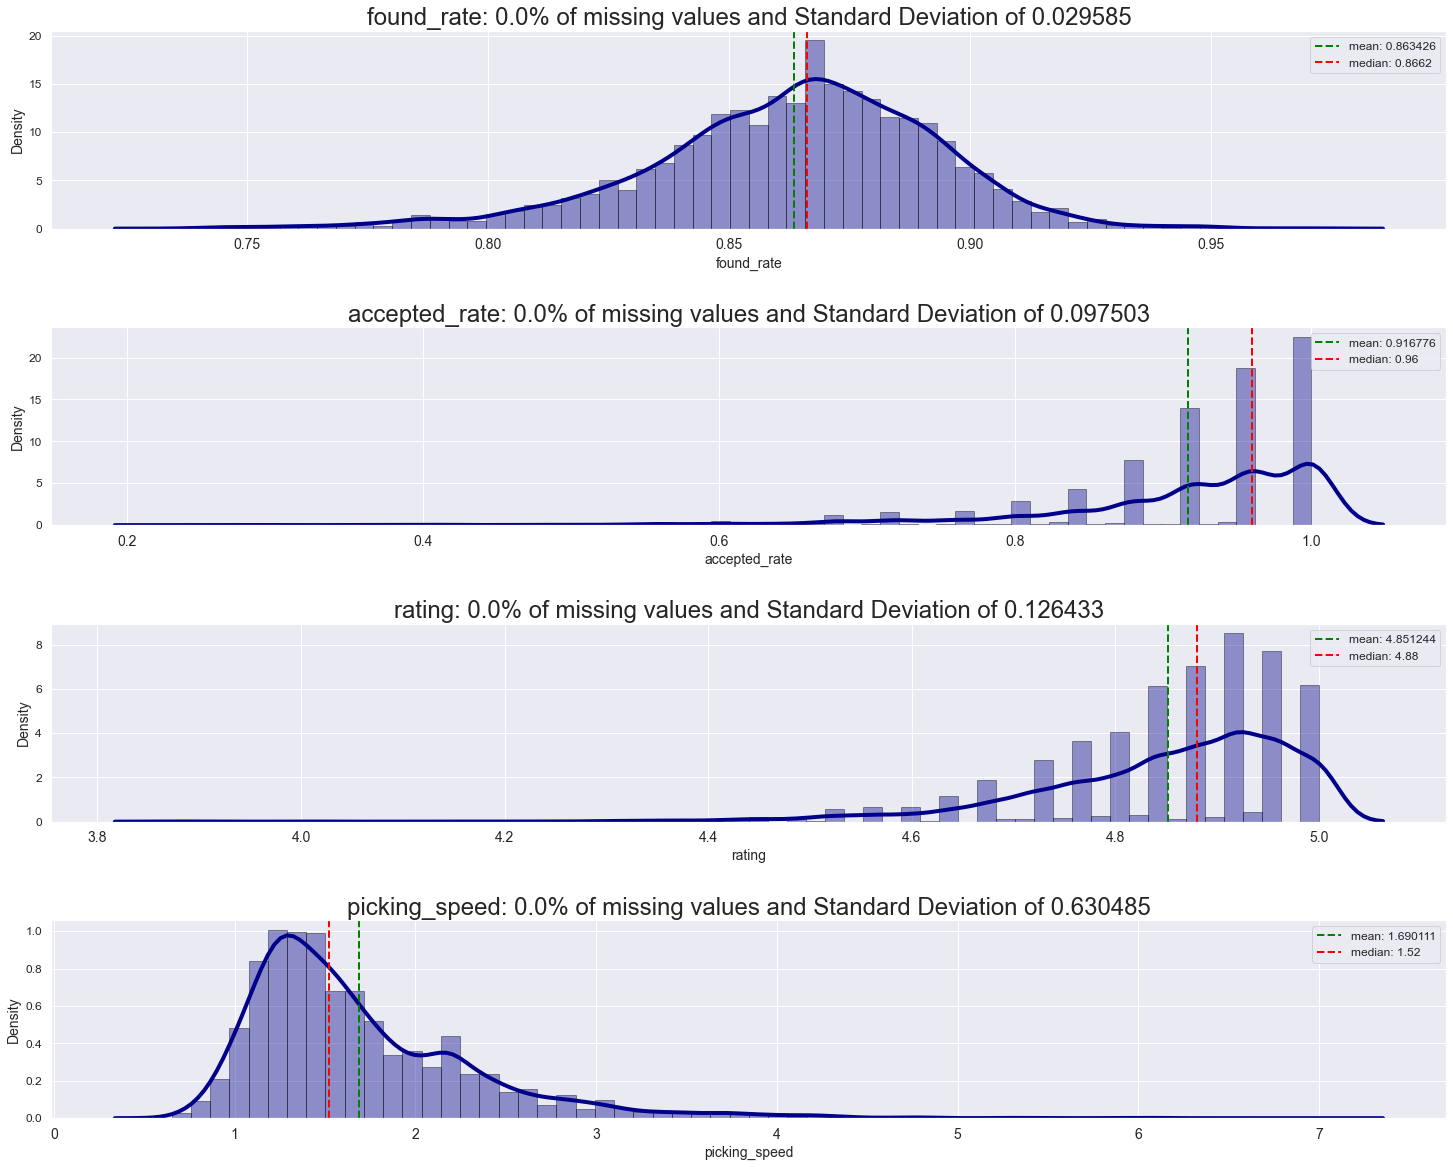

In [15]:
macro = df_prep.groupby(by='order_id').mean()

fig = plt.figure(figsize=(25,20))
fig.subplots_adjust(hspace=0.5, wspace=0.2)

j=1
for i in ['found_rate','accepted_rate','rating', 'picking_speed']:
    plot = plt.subplot(4, 1, j)
    ax = sns.distplot(macro[i], hist=True, kde=True, 
             bins=int(180/3), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
    
    ax.axvline(macro[i].mean(), 
               color='green', 
               linestyle='dashed', 
               linewidth=2, 
               label=f"mean: {str(macro[i].mean().round(6))}")
    
    ax.axvline(macro[i].median(), 
               color='red', 
               linestyle='dashed', 
               linewidth=2, 
               label=f"median: {str(macro[i].median().round(6))}")
    
    plt.title(f"{i}: {round(len(macro[i][macro[i].isnull()==True])/len(macro[i]) * 100, 2)}% of missing values and Standard Deviation of {str(macro[i].std().round(6))}")
    plt.legend(loc='upper right')
    j += 1

del ax

### Resources: quantity and buy_unit

In [16]:
nullListIdx = list(df_prep[df_prep.buy_unit.isnull()==True].index)
df_prep[df_prep.buy_unit.isnull()==True].iloc[:,-4:-1]

,product_id,quantity,buy_unit
5431,NaN,NaN,NaN
10962,NaN,NaN,NaN
18612,NaN,NaN,NaN
24788,NaN,NaN,NaN
26994,NaN,NaN,NaN
48813,NaN,NaN,NaN
63438,NaN,NaN,NaN
70214,NaN,NaN,NaN
79583,NaN,NaN,NaN
85236,NaN,NaN,NaN


In [17]:
df_prep[['quantity']][(df_prep.buy_unit=='UN')].describe().T

,count,mean,std,min,25%,50%,75%,max
quantity,144136.0,1.908219,1.951855,1.0,1.0,1.0,2.0,70.0


In [18]:
df_prep[['quantity']][(df_prep.buy_unit=='KG')].describe().T

,count,mean,std,min,25%,50%,75%,max
quantity,14172.0,0.971738,0.723309,0.055,0.498,0.835,1.2,16.25


In [19]:
print(f"Quantity mean (unit): {df_prep[(df_prep.buy_unit=='UN')]['quantity'].mean()}")
print(f"Quantity median (unit): {df_prep[(df_prep.buy_unit=='UN')]['quantity'].median()}")

Quantity mean (unit): 1.908218626852417
Quantity median (unit): 1.0


In [20]:
print(f"Quantity mean (kg): {df_prep[(df_prep.buy_unit=='KG')]['quantity'].mean()}")
print(f"Quantity median (kg): {df_prep[(df_prep.buy_unit=='KG')]['quantity'].median()}")

Quantity mean (kg): 0.971737554685295
Quantity median (kg): 0.835


There are order_id in orders.csv that aren't in order_products.csv. Since I don't know if the products associated with these orders were bought in units or kg, I'll simply replace the missing values to the corresponding quantity-median.

**DECISION:** Replace it by median, since it's less affected by outliers

In [21]:
# quantity
replaceNull(
    df_prep,
    'quantity',
    df_prep['quantity'].median()
)

### Checking remaining missings

In [22]:
df_prep.isnull().sum()

order_id            0
lat_order           0
lng_order           0
promised_time       0
on_demand           0
shopper_id          0
store_branch_id     0
total_minutes       0
seniority           0
found_rate          0
picking_speed       0
accepted_rate       0
rating              0
store_id            0
lat_storebranch     0
lng_storebranch     0
product_id         17
quantity            0
buy_unit           17
item                0
dtype: int64

**Notice that:** the resources **product_id** and **buy_unit** won't be used to predict **total_minutes**, since the first one is just an id and the latter is correlated to quantity.

## Feature Engineering

In [23]:
### So far...
print(df_prep.shape)
df_prep.head()

(158325, 20)


,order_id,lat_order,lng_order,promised_time,on_demand,shopper_id,store_branch_id,total_minutes,seniority,found_rate,picking_speed,accepted_rate,rating,store_id,lat_storebranch,lng_storebranch,product_id,quantity,buy_unit,item
0,e750294655c2c7c34d83cc3181c09de4,-33.501675,-70.579369,2019-10-18 20:48:00+00:00,True,e63bc83a1a952fa2b3cc9d558fb943cf,65ded5353c5ee48d0b7d48c591b8f430,67.684264,6c90661e6d2c7579f5ce337c3391dbb9,0.9024,1.3,0.92,4.76,c4ca4238a0b923820dcc509a6f75849b,-33.48528,-70.57925,fb3336fca8851437f980e83045e75749,0.581,KG,1
1,e750294655c2c7c34d83cc3181c09de4,-33.501675,-70.579369,2019-10-18 20:48:00+00:00,True,e63bc83a1a952fa2b3cc9d558fb943cf,65ded5353c5ee48d0b7d48c591b8f430,67.684264,6c90661e6d2c7579f5ce337c3391dbb9,0.9024,1.3,0.92,4.76,c4ca4238a0b923820dcc509a6f75849b,-33.48528,-70.57925,dab05166de7d42c526f5627acad97902,1.000,UN,1
2,e750294655c2c7c34d83cc3181c09de4,-33.501675,-70.579369,2019-10-18 20:48:00+00:00,True,e63bc83a1a952fa2b3cc9d558fb943cf,65ded5353c5ee48d0b7d48c591b8f430,67.684264,6c90661e6d2c7579f5ce337c3391dbb9,0.9024,1.3,0.92,4.76,c4ca4238a0b923820dcc509a6f75849b,-33.48528,-70.57925,c49f0bd639bcbee3c331abdb48b653da,1.000,UN,1
3,e750294655c2c7c34d83cc3181c09de4,-33.501675,-70.579369,2019-10-18 20:48:00+00:00,True,e63bc83a1a952fa2b3cc9d558fb943cf,65ded5353c5ee48d0b7d48c591b8f430,67.684264,6c90661e6d2c7579f5ce337c3391dbb9,0.9024,1.3,0.92,4.76,c4ca4238a0b923820dcc509a6f75849b,-33.48528,-70.57925,16984fbb57316494a14543ad6d70a2e8,1.000,UN,1
4,e750294655c2c7c34d83cc3181c09de4,-33.501675,-70.579369,2019-10-18 20:48:00+00:00,True,e63bc83a1a952fa2b3cc9d558fb943cf,65ded5353c5ee48d0b7d48c591b8f430,67.684264,6c90661e6d2c7579f5ce337c3391dbb9,0.9024,1.3,0.92,4.76,c4ca4238a0b923820dcc509a6f75849b,-33.48528,-70.57925,fbfb98804142023129c9475f72db5b08,1.000,UN,1


### Creating the resources: day_of_week and pure_time

In [24]:
dateTimeConverter(df_prep, 'promised_time')
print(df_prep.shape)
df_prep.head()

(158325, 24)


,order_id,lat_order,lng_order,promised_time,on_demand,shopper_id,store_branch_id,total_minutes,seniority,found_rate,picking_speed,accepted_rate,rating,store_id,lat_storebranch,lng_storebranch,product_id,quantity,buy_unit,item,day_of_week,promised_time_DATE,promised_time_HOUR,pure_time
0,e750294655c2c7c34d83cc3181c09de4,-33.501675,-70.579369,2019-10-18 20:48:00+00:00,True,e63bc83a1a952fa2b3cc9d558fb943cf,65ded5353c5ee48d0b7d48c591b8f430,67.684264,6c90661e6d2c7579f5ce337c3391dbb9,0.9024,1.3,0.92,4.76,c4ca4238a0b923820dcc509a6f75849b,-33.48528,-70.57925,fb3336fca8851437f980e83045e75749,0.581,KG,1,friday,2019-10-18,20:48:00,20.8
1,e750294655c2c7c34d83cc3181c09de4,-33.501675,-70.579369,2019-10-18 20:48:00+00:00,True,e63bc83a1a952fa2b3cc9d558fb943cf,65ded5353c5ee48d0b7d48c591b8f430,67.684264,6c90661e6d2c7579f5ce337c3391dbb9,0.9024,1.3,0.92,4.76,c4ca4238a0b923820dcc509a6f75849b,-33.48528,-70.57925,dab05166de7d42c526f5627acad97902,1.000,UN,1,friday,2019-10-18,20:48:00,20.8
2,e750294655c2c7c34d83cc3181c09de4,-33.501675,-70.579369,2019-10-18 20:48:00+00:00,True,e63bc83a1a952fa2b3cc9d558fb943cf,65ded5353c5ee48d0b7d48c591b8f430,67.684264,6c90661e6d2c7579f5ce337c3391dbb9,0.9024,1.3,0.92,4.76,c4ca4238a0b923820dcc509a6f75849b,-33.48528,-70.57925,c49f0bd639bcbee3c331abdb48b653da,1.000,UN,1,friday,2019-10-18,20:48:00,20.8
3,e750294655c2c7c34d83cc3181c09de4,-33.501675,-70.579369,2019-10-18 20:48:00+00:00,True,e63bc83a1a952fa2b3cc9d558fb943cf,65ded5353c5ee48d0b7d48c591b8f430,67.684264,6c90661e6d2c7579f5ce337c3391dbb9,0.9024,1.3,0.92,4.76,c4ca4238a0b923820dcc509a6f75849b,-33.48528,-70.57925,16984fbb57316494a14543ad6d70a2e8,1.000,UN,1,friday,2019-10-18,20:48:00,20.8
4,e750294655c2c7c34d83cc3181c09de4,-33.501675,-70.579369,2019-10-18 20:48:00+00:00,True,e63bc83a1a952fa2b3cc9d558fb943cf,65ded5353c5ee48d0b7d48c591b8f430,67.684264,6c90661e6d2c7579f5ce337c3391dbb9,0.9024,1.3,0.92,4.76,c4ca4238a0b923820dcc509a6f75849b,-33.48528,-70.57925,fbfb98804142023129c9475f72db5b08,1.000,UN,1,friday,2019-10-18,20:48:00,20.8


**Notice that:** The resource **product_id** is just an id, it won't be used to predict **total_minutes**, neither **buy_units**

### Creating the resource: distance

In [25]:
calculateDistance(df_prep, 'lat_order', 'lng_order', 'lat_storebranch', 'lng_storebranch')
print(df_prep.shape)
df_prep.head()

(158325, 27)


,order_id,lat_order,lng_order,promised_time,on_demand,shopper_id,store_branch_id,total_minutes,seniority,found_rate,picking_speed,accepted_rate,rating,store_id,lat_storebranch,lng_storebranch,product_id,quantity,buy_unit,item,day_of_week,promised_time_DATE,promised_time_HOUR,pure_time,coordsX,coordsY,distance
0,e750294655c2c7c34d83cc3181c09de4,-33.501675,-70.579369,2019-10-18 20:48:00+00:00,True,e63bc83a1a952fa2b3cc9d558fb943cf,65ded5353c5ee48d0b7d48c591b8f430,67.684264,6c90661e6d2c7579f5ce337c3391dbb9,0.9024,1.3,0.92,4.76,c4ca4238a0b923820dcc509a6f75849b,-33.48528,-70.57925,fb3336fca8851437f980e83045e75749,0.581,KG,1,friday,2019-10-18,20:48:00,20.8,"(-33.5016745551528, -33.5016745551528)","(-33.48528, -33.48528)",2.372267
1,e750294655c2c7c34d83cc3181c09de4,-33.501675,-70.579369,2019-10-18 20:48:00+00:00,True,e63bc83a1a952fa2b3cc9d558fb943cf,65ded5353c5ee48d0b7d48c591b8f430,67.684264,6c90661e6d2c7579f5ce337c3391dbb9,0.9024,1.3,0.92,4.76,c4ca4238a0b923820dcc509a6f75849b,-33.48528,-70.57925,dab05166de7d42c526f5627acad97902,1.000,UN,1,friday,2019-10-18,20:48:00,20.8,"(-33.5016745551528, -33.5016745551528)","(-33.48528, -33.48528)",2.372267
2,e750294655c2c7c34d83cc3181c09de4,-33.501675,-70.579369,2019-10-18 20:48:00+00:00,True,e63bc83a1a952fa2b3cc9d558fb943cf,65ded5353c5ee48d0b7d48c591b8f430,67.684264,6c90661e6d2c7579f5ce337c3391dbb9,0.9024,1.3,0.92,4.76,c4ca4238a0b923820dcc509a6f75849b,-33.48528,-70.57925,c49f0bd639bcbee3c331abdb48b653da,1.000,UN,1,friday,2019-10-18,20:48:00,20.8,"(-33.5016745551528, -33.5016745551528)","(-33.48528, -33.48528)",2.372267
3,e750294655c2c7c34d83cc3181c09de4,-33.501675,-70.579369,2019-10-18 20:48:00+00:00,True,e63bc83a1a952fa2b3cc9d558fb943cf,65ded5353c5ee48d0b7d48c591b8f430,67.684264,6c90661e6d2c7579f5ce337c3391dbb9,0.9024,1.3,0.92,4.76,c4ca4238a0b923820dcc509a6f75849b,-33.48528,-70.57925,16984fbb57316494a14543ad6d70a2e8,1.000,UN,1,friday,2019-10-18,20:48:00,20.8,"(-33.5016745551528, -33.5016745551528)","(-33.48528, -33.48528)",2.372267
4,e750294655c2c7c34d83cc3181c09de4,-33.501675,-70.579369,2019-10-18 20:48:00+00:00,True,e63bc83a1a952fa2b3cc9d558fb943cf,65ded5353c5ee48d0b7d48c591b8f430,67.684264,6c90661e6d2c7579f5ce337c3391dbb9,0.9024,1.3,0.92,4.76,c4ca4238a0b923820dcc509a6f75849b,-33.48528,-70.57925,fbfb98804142023129c9475f72db5b08,1.000,UN,1,friday,2019-10-18,20:48:00,20.8,"(-33.5016745551528, -33.5016745551528)","(-33.48528, -33.48528)",2.372267


### Creating the resources: number of itens, weight and distinct items per order

In [26]:
calculateItem(df_prep, 'buy_unit', 'quantity')
df_prep[['quantity','no_item','weight','item']].head()

,quantity,no_item,weight,item
0,0.581,1.0,0.581,1
1,1.000,1.0,0.000,1
2,1.000,1.0,0.000,1
3,1.000,1.0,0.000,1
4,1.000,1.0,0.000,1


In [27]:
df_prep.groupby(by='order_id').sum('quantity').head()

,lat_order,lng_order,on_demand,total_minutes,found_rate,picking_speed,accepted_rate,rating,lat_storebranch,lng_storebranch,quantity,item,pure_time,distance,no_item,weight
order_id,,,,,,,,,,,,,,,,
0004a3841c1eeb6c6e77585a941c21e0,-133.562202,-282.264426,4,156.005855,3.3892,9.20,3.680000,19.52,-133.546188,-282.272301,8.000,4,81.20,2.318214,8.0,0.000
0005a6ecbbde1e8d273f5577bcff2c9c,-33.352935,-70.513225,1,41.164442,0.8407,1.57,0.840000,4.72,-33.359768,-70.543273,2.000,1,21.15,0.989345,2.0,0.000
0007baeb6700fc203be2d1f1e11222d7,-735.071808,-1552.703646,0,3001.967960,19.8264,55.00,22.000000,108.24,-734.504036,-1552.497657,39.000,22,0.00,82.191509,39.0,0.000
0012195a6a8ca9ec308a3010eeea8ebc,-367.345175,-776.139825,0,801.389575,9.6591,13.97,10.120000,53.68,-367.252018,-776.248828,13.000,11,198.00,13.486072,13.0,0.000
0013011fa72b498b9feb84f4e7104980,-1470.835588,-3104.023578,0,6293.800450,36.5244,137.28,37.714286,220.00,-1471.414824,-3103.559800,64.636,44,0.00,83.837478,65.0,1.636


## Selecting Possible Useful Resources

In [28]:
list(df_prep)

['order_id',
 'lat_order',
 'lng_order',
 'promised_time',
 'on_demand',
 'shopper_id',
 'store_branch_id',
 'total_minutes',
 'seniority',
 'found_rate',
 'picking_speed',
 'accepted_rate',
 'rating',
 'store_id',
 'lat_storebranch',
 'lng_storebranch',
 'product_id',
 'quantity',
 'buy_unit',
 'item',
 'day_of_week',
 'promised_time_DATE',
 'promised_time_HOUR',
 'pure_time',
 'coordsX',
 'coordsY',
 'distance',
 'no_item',
 'weight']

In [29]:
selected = [
'order_id', #-> index!
#'lat_order',
#'lng_order',
#'promised_time',
'on_demand',
#'shopper_id',
#'store_branch_id',
'total_minutes', #-> TARGET!
'seniority',
'found_rate',
'picking_speed',
'accepted_rate',
'rating',
#'store_id',
#'lat_storebranch',
#'lng_storebranch',
#'product_id',
'quantity',
#'buy_unit',
'item',
'day_of_week',
#'promised_time_DATE',
#'promised_time_HOUR',
'pure_time',
#'coordsX',
#'coordsY',
'distance',
'no_item',
#'weight'
]

In [30]:
df_prep[selected]

,order_id,on_demand,total_minutes,seniority,found_rate,picking_speed,accepted_rate,rating,quantity,item,day_of_week,pure_time,distance,no_item
0,e750294655c2c7c34d83cc3181c09de4,True,67.684264,6c90661e6d2c7579f5ce337c3391dbb9,0.9024,1.30,0.92,4.76,0.581,1,friday,20.8,2.372267,1.0
1,e750294655c2c7c34d83cc3181c09de4,True,67.684264,6c90661e6d2c7579f5ce337c3391dbb9,0.9024,1.30,0.92,4.76,1.000,1,friday,20.8,2.372267,1.0
2,e750294655c2c7c34d83cc3181c09de4,True,67.684264,6c90661e6d2c7579f5ce337c3391dbb9,0.9024,1.30,0.92,4.76,1.000,1,friday,20.8,2.372267,1.0
3,e750294655c2c7c34d83cc3181c09de4,True,67.684264,6c90661e6d2c7579f5ce337c3391dbb9,0.9024,1.30,0.92,4.76,1.000,1,friday,20.8,2.372267,1.0
4,e750294655c2c7c34d83cc3181c09de4,True,67.684264,6c90661e6d2c7579f5ce337c3391dbb9,0.9024,1.30,0.92,4.76,1.000,1,friday,20.8,2.372267,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158320,ac9520e37e420842ce36b65a71b48954,True,55.111234,6c90661e6d2c7579f5ce337c3391dbb9,0.8946,1.82,1.00,4.84,2.000,1,saturday,1.0,2.405919,2.0
158321,ac9520e37e420842ce36b65a71b48954,True,55.111234,6c90661e6d2c7579f5ce337c3391dbb9,0.8946,1.82,1.00,4.84,1.000,1,saturday,1.0,2.405919,1.0
158322,ac9520e37e420842ce36b65a71b48954,True,55.111234,6c90661e6d2c7579f5ce337c3391dbb9,0.8946,1.82,1.00,4.84,2.000,1,saturday,1.0,2.405919,2.0
158323,ac9520e37e420842ce36b65a71b48954,True,55.111234,6c90661e6d2c7579f5ce337c3391dbb9,0.8946,1.82,1.00,4.84,1.000,1,saturday,1.0,2.405919,1.0


In [31]:
df_prep_macro = df_prep[selected].groupby(by=[
    'order_id',
    'seniority',
    'on_demand',
    'day_of_week'
], as_index=False).agg(
    {
        'total_minutes':['mean'],
        'pure_time':['mean'],
        'found_rate':['mean'],
        'picking_speed':['mean'],
        'accepted_rate':['mean'],
        'rating':['mean'],
        'distance':['mean'],
        'no_item':['sum'],
        'quantity':['sum'],
        'item':['sum']
    }
).copy()

df_prep_macro.columns = df_prep_macro.columns.droplevel(1)
df_prep_macro

,order_id,seniority,on_demand,day_of_week,total_minutes,pure_time,found_rate,picking_speed,accepted_rate,rating,distance,no_item,quantity,item
0,0004a3841c1eeb6c6e77585a941c21e0,41dc7c9e385c4d2b6c1f7836973951bf,True,friday,39.001464,20.300000,0.8473,2.30,0.920000,4.88,0.579554,8.0,8.000,4
1,0005a6ecbbde1e8d273f5577bcff2c9c,50e13ee63f086c2fe84229348bc91b5b,True,friday,41.164442,21.150000,0.8407,1.57,0.840000,4.72,0.989345,2.0,2.000,1
2,0007baeb6700fc203be2d1f1e11222d7,41dc7c9e385c4d2b6c1f7836973951bf,False,saturday,136.453089,0.000000,0.9012,2.50,1.000000,4.92,3.735978,39.0,39.000,22
3,0012195a6a8ca9ec308a3010eeea8ebc,6c90661e6d2c7579f5ce337c3391dbb9,False,saturday,72.853598,18.000000,0.8781,1.27,0.920000,4.88,1.226007,13.0,13.000,11
4,0013011fa72b498b9feb84f4e7104980,50e13ee63f086c2fe84229348bc91b5b,False,saturday,143.040919,0.000000,0.8301,3.12,0.857143,5.00,1.905397,65.0,64.636,44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,ffc3234b2e009e5422a4b5e24961c038,6c90661e6d2c7579f5ce337c3391dbb9,False,saturday,92.146266,15.000000,0.8853,1.30,1.000000,4.76,5.799480,16.0,18.100,15
7996,ffcc66cd4d1056b67523a39ff07d7700,6c90661e6d2c7579f5ce337c3391dbb9,True,friday,57.553529,22.316667,0.8973,0.97,1.000000,4.84,0.333459,72.0,72.015,40
7997,ffcf270be4bba33349ce827c70fe9439,6c90661e6d2c7579f5ce337c3391dbb9,False,saturday,103.938002,17.000000,0.8981,1.37,0.960000,4.80,4.513264,53.0,52.332,22
7998,ffdbc12cfcf7101a517a7eb7e1776c43,50e13ee63f086c2fe84229348bc91b5b,True,saturday,40.134711,14.716667,0.8771,1.07,0.840000,4.92,1.391585,39.0,39.602,23


## Outlier Analysis

In [32]:
listOutliers = [
    'found_rate',
    'picking_speed',
    'accepted_rate',
    'rating',
    'pure_time',
    'distance',
    'item',
    'no_item',
    'quantity'
]

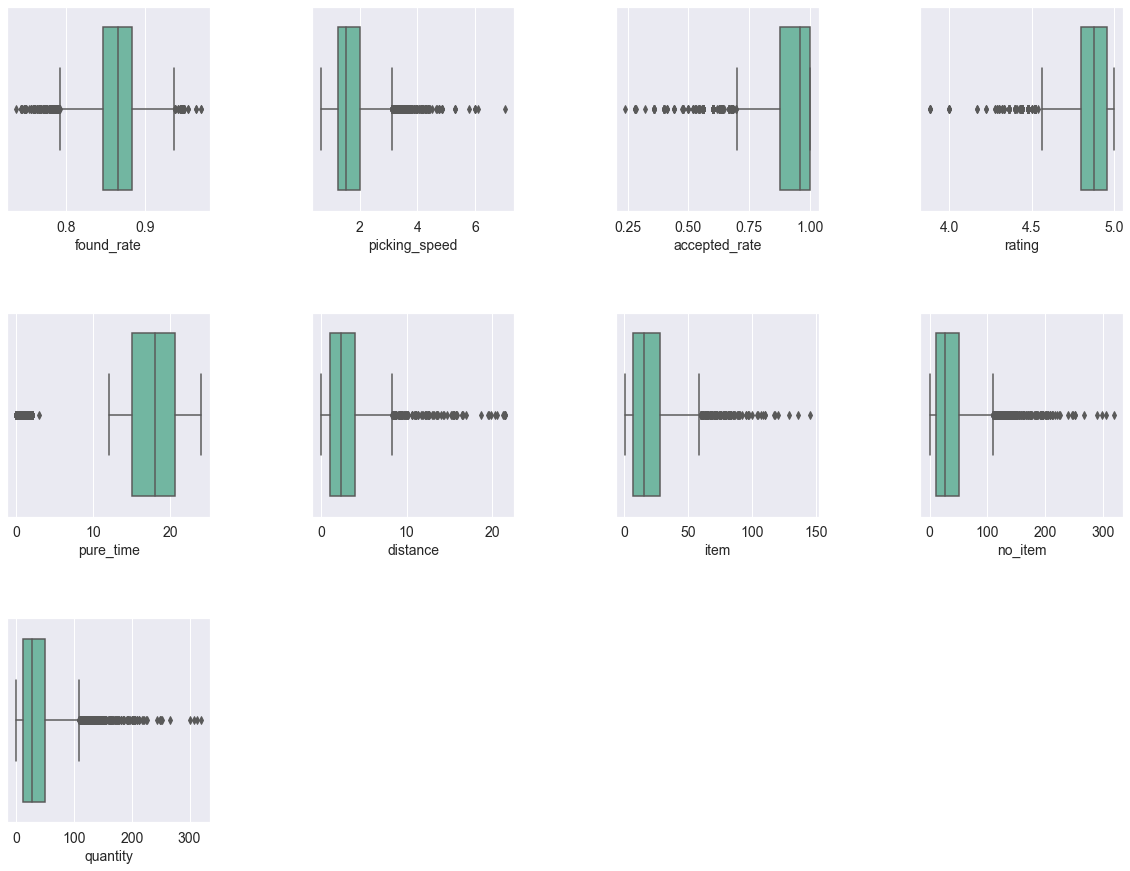

In [33]:
fig = plt.figure(figsize=(20,15))
fig.subplots_adjust(hspace=0.5, wspace=0.5)
j=1
for i in listOutliers:
    plot = plt.subplot(3, 4, j)
    ax = sns.boxplot(x=df_prep_macro[i])
    plt.xlabel(f"{i}")
    #plt.semilogx()
    j += 1

del ax, i, j

* The only resource I'll will adjust is the **pure_time**
    1. all values lesser than 10 will be freezed at percentile 0.25
    1. all values grater than 21 will be freezed at percentile 0.75
* Simply because 10h to 21h is period of time that makes sense for deliveries.

### Percentile-Freeze

In [34]:
df_freezed, table = funcFreezeOutlier(df_prep_macro, ['pure_time'], 0.75, ifHigh=True)
df_prep_macro = df_freezed.copy()
del df_freezed
table

,PERCENTILE,FREEZED VALUE,COUNT
pure_time,75.0,20.666667,1999


In [35]:
dictOutlier1 = {}
for val in table['FREEZED VALUE'].index:
    dictOutlier1[val] = table['FREEZED VALUE'][val]
    
dictOutlier1

{'pure_time': 20.666666666666668}

In [36]:
df_freezed, table = funcFreezeOutlier(df_prep_macro, ['pure_time'], 0.25, ifHigh=False)
df_prep_macro = df_freezed.copy()
del df_freezed
table

,PERCENTILE,FREEZED VALUE,COUNT
pure_time,25.0,15.0,1896


In [37]:
dictOutlier2 = {}
for val in table['FREEZED VALUE'].index:
    dictOutlier2[val] = table['FREEZED VALUE'][val]
    
dictOutlier2

{'pure_time': 15.0}

### Exporting Outlier Dictionary

In [38]:
with open(f"{DATE}_outlier_dict_high.txt", 'w') as convert_file: 
    convert_file.write(json.dumps(dictOutlier1, ensure_ascii=False))
    
with open(f"{DATE}_outlier_dict_low.txt", 'w') as convert_file: 
    convert_file.write(json.dumps(dictOutlier2, ensure_ascii=False))

## Saving preprocessed dataset

In [39]:
df_prep_macro

,order_id,seniority,on_demand,day_of_week,total_minutes,pure_time,found_rate,picking_speed,accepted_rate,rating,distance,no_item,quantity,item
0,0004a3841c1eeb6c6e77585a941c21e0,41dc7c9e385c4d2b6c1f7836973951bf,True,friday,39.001464,20.300000,0.8473,2.30,0.920000,4.88,0.579554,8.0,8.000,4
1,0005a6ecbbde1e8d273f5577bcff2c9c,50e13ee63f086c2fe84229348bc91b5b,True,friday,41.164442,20.666667,0.8407,1.57,0.840000,4.72,0.989345,2.0,2.000,1
2,0007baeb6700fc203be2d1f1e11222d7,41dc7c9e385c4d2b6c1f7836973951bf,False,saturday,136.453089,15.000000,0.9012,2.50,1.000000,4.92,3.735978,39.0,39.000,22
3,0012195a6a8ca9ec308a3010eeea8ebc,6c90661e6d2c7579f5ce337c3391dbb9,False,saturday,72.853598,18.000000,0.8781,1.27,0.920000,4.88,1.226007,13.0,13.000,11
4,0013011fa72b498b9feb84f4e7104980,50e13ee63f086c2fe84229348bc91b5b,False,saturday,143.040919,15.000000,0.8301,3.12,0.857143,5.00,1.905397,65.0,64.636,44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,ffc3234b2e009e5422a4b5e24961c038,6c90661e6d2c7579f5ce337c3391dbb9,False,saturday,92.146266,15.000000,0.8853,1.30,1.000000,4.76,5.799480,16.0,18.100,15
7996,ffcc66cd4d1056b67523a39ff07d7700,6c90661e6d2c7579f5ce337c3391dbb9,True,friday,57.553529,20.666667,0.8973,0.97,1.000000,4.84,0.333459,72.0,72.015,40
7997,ffcf270be4bba33349ce827c70fe9439,6c90661e6d2c7579f5ce337c3391dbb9,False,saturday,103.938002,17.000000,0.8981,1.37,0.960000,4.80,4.513264,53.0,52.332,22
7998,ffdbc12cfcf7101a517a7eb7e1776c43,50e13ee63f086c2fe84229348bc91b5b,True,saturday,40.134711,15.000000,0.8771,1.07,0.840000,4.92,1.391585,39.0,39.602,23


In [40]:
df_prep_macro = pd.get_dummies(df_prep_macro, columns = ['seniority'])
df_prep_macro.head()

,order_id,on_demand,day_of_week,total_minutes,pure_time,found_rate,picking_speed,accepted_rate,rating,distance,no_item,quantity,item,seniority_41dc7c9e385c4d2b6c1f7836973951bf,seniority_50e13ee63f086c2fe84229348bc91b5b,seniority_6c90661e6d2c7579f5ce337c3391dbb9,seniority_bb29b8d0d196b5db5a5350e5e3ae2b1f
0,0004a3841c1eeb6c6e77585a941c21e0,True,friday,39.001464,20.300000,0.8473,2.30,0.920000,4.88,0.579554,8.0,8.000,4,1,0,0,0
1,0005a6ecbbde1e8d273f5577bcff2c9c,True,friday,41.164442,20.666667,0.8407,1.57,0.840000,4.72,0.989345,2.0,2.000,1,0,1,0,0
2,0007baeb6700fc203be2d1f1e11222d7,False,saturday,136.453089,15.000000,0.9012,2.50,1.000000,4.92,3.735978,39.0,39.000,22,1,0,0,0
3,0012195a6a8ca9ec308a3010eeea8ebc,False,saturday,72.853598,18.000000,0.8781,1.27,0.920000,4.88,1.226007,13.0,13.000,11,0,0,1,0
4,0013011fa72b498b9feb84f4e7104980,False,saturday,143.040919,15.000000,0.8301,3.12,0.857143,5.00,1.905397,65.0,64.636,44,0,1,0,0


In [41]:
df_prep_macro.to_csv(PATH_DATA + DATE + '_prep_' + DATASET_TT,
             sep=',',
             index=False)